# Introduction to PyMC3

Before jumping into cooler and more complex models, we are going to try out PyMC3 with some simple regression models. For most of these examples, non-Bayesian methods would be more than appropriate, but we need to start from some basics, so that we can learn how to use the library correctly.

**Outline of this notebook** : 
 
 - Example 1: Linear Regression
 - Exercise 1: first parameter estimation
 - Example 2: Non-linear Regression
 - Exercise 2: Linear Regression with noise confounders



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

import statsmodels.api as sm
#import arviz as az


x = np.linspace(0, 3, 100)
data_t = -1 + 0.5 * x + 0.1 * np.random.randn(1,len(x))
data_outliers = data_t.copy()
data_outliers[:,10] = 0
data_outliers[:,80] = -.5

data_h = -1 + 0.5 * x + x * 0.3 * abs(np.random.randn(1,len(x))) + 0.1 * abs(np.random.randn(1,len(x)))

car_t = np.linspace(0,3, 100)
car_v = 5 * (car_t) + 2 * (np.random.randn(1,len(car_t)))**2



## Example 1: Linear Regression

In a linear regression problem, we are trying to estimate the parameters ($\beta, \alpha$) that best describe the data ($x, y$), assuming those come from a linear approximation, and possibly a noise term $\epsilon$

$ y = \beta x + \alpha + \epsilon $

Imagine we have an instrument that measures temperature at different depths (e.g. temperatures from the surface of a material). We know that the temperature varies linearly with depth but that the slope depends on the humidity of the room. Moreover, the measurement error increases in time and the instrument needs to be replaced when the variance is above XXX . 

We would like to estimate the slope $\beta$ and bias $\alpha$ so that we could estimate the humidity, while making sure the instrument is reliable ($\epsilon$)

### Below the measurements:

[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]


Text(0.5, 1.0, 'Observations')

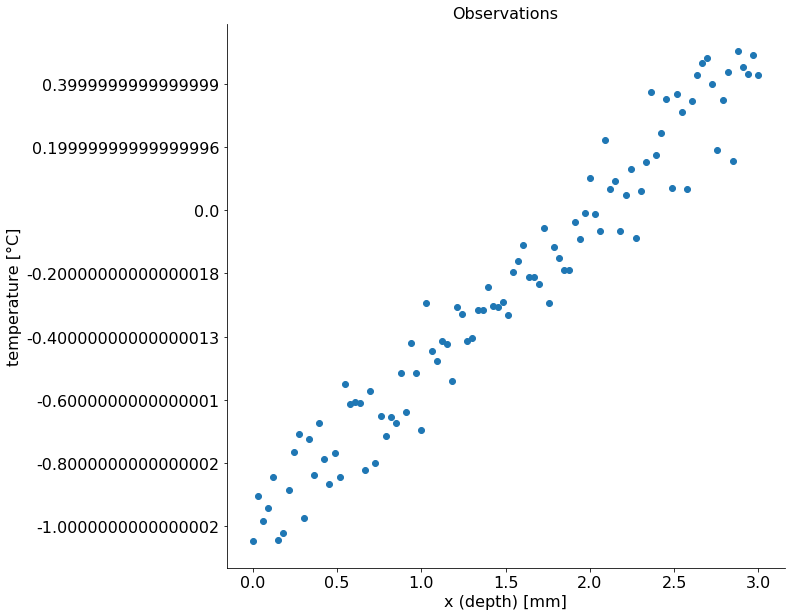

In [21]:
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)

print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1869.
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.23e-65
Time:                        22:00:27   Log-Likelihood:                 90.059
No. Observations:                 100   AIC:                            -176.1
Df Residuals:                      98   BIC:                            -170.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9953      0.020    -50.486      0.0

Text(0.5, 1.0, 'Observations')

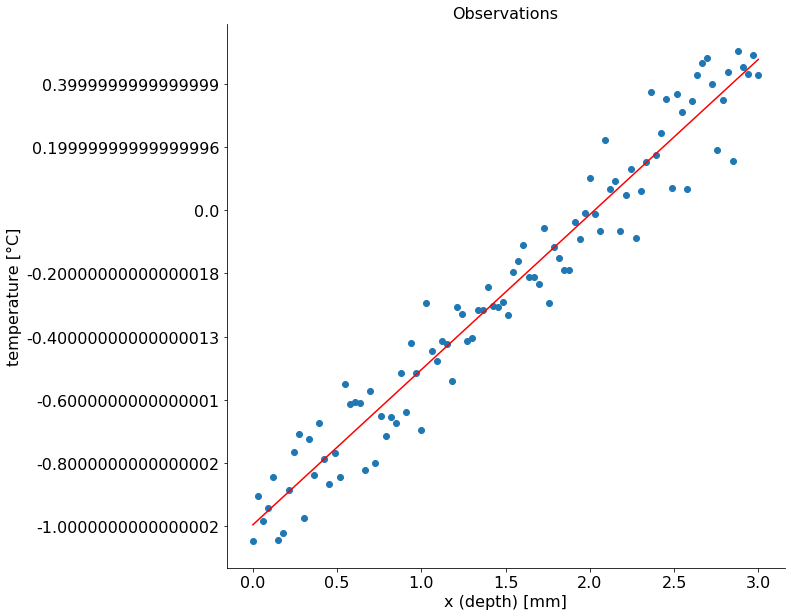

In [22]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_t.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


As we mentioned before, for Bayesian inference we need to first make a full model described by appropriate probability distributions.

**Model**
$ y = \beta x + \alpha + \epsilon $

**Likelihood of the data**

Measures are usually normally distributed around the actual temperature values. 

$ y \sim N ( \beta x + \alpha, \epsilon ) $

**Priors of the parameters**:

  - Slope $\beta$, continuous values, $(-\inf, +\inf)$, we know it is usually between 0 and 1.
  - Bias $\alpha$, continuous values, $(-\inf, +\inf)$, the instrument we know has a bias of around $-1$
  - Variance $\epsilon$, continuous values, $(0, +\inf)$
 
$ \beta \sim N ( 0.5 , 1 ) $  
$ \alpha \sim N ( -1 , 1 ) $  
$ \epsilon \sim Gamma ( 1 , 1 ) $  

PyMC3 allows the user to specify the model in a very intuitive way. 



In [23]:
# Data
temperature = data_t
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha, epsilon]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:21<00:00, 1131.49draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7773d0710>,
      dtype=object)

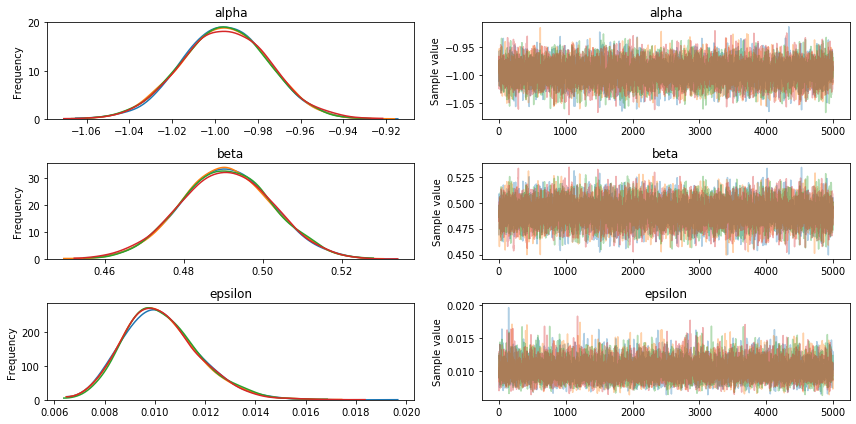

In [24]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

In [25]:
# Descriptive statistic of the posteriors

pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.995365,0.020128,0.000195,-1.033305,-0.954227,9274.337783,1.000024
beta,0.490817,0.011619,0.000112,0.467720,0.513348,9152.400826,0.999944
epsilon,0.010265,0.001488,0.000015,0.007427,0.013154,11452.313246,1.000069


Some further detail on PyMC inference:
 - What is the burn-in?
 - what changes with a different prior?


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [epsilon]
Sampling 2 chains: 100%|██████████| 20002/20002 [00:07<00:00, 2826.98draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


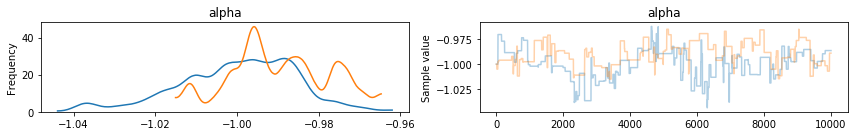

In [26]:
# What is the burnin? 

### We use now a metropolis sampler, that makes more clear what the burnin period is 
SAMPLES = 10000
with model:
    trace = pm.sample(SAMPLES, step=pm.Metropolis(), chains=2, tune = 1)

# Built-in functions for data visualisation
pm.traceplot(trace, varnames=['alpha'])

a1 = trace['alpha']

In [27]:
# What happens if the prior is less informative?
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', 0, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [epsilon]
Sampling 2 chains: 100%|██████████| 20002/20002 [00:07<00:00, 2592.54draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


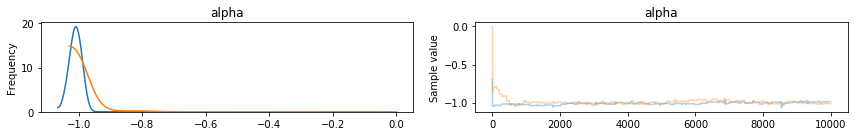

In [28]:
### We use now a metropolis sampler, that makes more clear what the burnin period is 
SAMPLES = 10000
with model:
    trace = pm.sample(SAMPLES, step=pm.Metropolis(),init=False, chains=2, tune = 1)

# Built-in functions for data visualisation
pm.traceplot(trace, varnames=['alpha'])

a2 = trace['alpha']



Text(0.5, 1.0, 'First 1000 samples , alpha = N(0,1)')

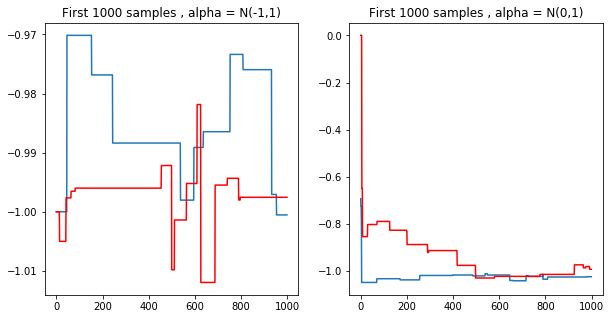

In [29]:
# Comparison of the two traces, remember we used 2 chains
f,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(a1[:1000])
ax[0].plot(a1[SAMPLES:SAMPLES+1000], 'r')
ax[0].set_title('First 1000 samples , alpha = N(-1,1)')
ax[1].plot(a2[:1000])
ax[1].plot(a2[SAMPLES:SAMPLES+1000], 'r')
ax[1].set_title('First 1000 samples , alpha = N(0,1)')


## Exercise 1 

Try to estimate the parameters in the following  scenarios ( they might ring a bell )

a) Estimate the actual temperature of the room, having multiple recordings from different termometers

In [30]:
# Solve Exercise 1a here
temperature = [20 , 21, 20.5, 19.8, 19.7, 20.1, 20.6, 18.9, ]

# Plot the data 

# Build the model, remember the definition in PyMC3
# with pm.Model() as model_name: ...


In [31]:
# Evaluate the posterior


In [32]:
# What can we say on the posterior? Show the summary statistics and some plot


b) What is the number of points Mark is expected to make during the next tournament 3PC ? During the last trainings he scored 18/25, 22/25, 17/25, 21/25.

In [33]:
# Solve Exercise 1b here


c) How many absent students should we expect during the next week, given that during the last month, out of 25, 
we recorded 24,23,24,24,24,24,25,25,25,20,19,20,22,21,24,25,25,24,25,24,22,23,20,10,25,24,23,25,20,21 students in the classroom.


In [34]:
# Solve Exercise 1c here


## Example 3: Non-linear Regression

Adapted from https://docs.pymc.io/notebooks/GLM-poisson-regression.html

As explained before, regression with PyMC can be applied to multiple types of data, as long as the model is coherent with the data. We try now to apply it to some temporal data, using a GLM.

We want now to regress the sneezes of an individual under antihistamine medication.

- The subject sneezes N times per day, recorded as nsneeze (int)
- The subject may or may not take an antihistamine medication during that day, recorded as the negative action nomeds (boolean)
I postulate (probably incorrectly) that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken.
The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.


In [35]:
import pandas as pd
# decide poisson theta values
theta_meds = 1    # no alcohol, took an antihist
theta_nomeds = 4  # no alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_meds, q),
                                   np.random.poisson(theta_nomeds, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(True, q))) })

         nomeds
nsneeze  False     1.000
         True      3.979
dtype: float64


/home/viola/miniconda3/envs/smalldata/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


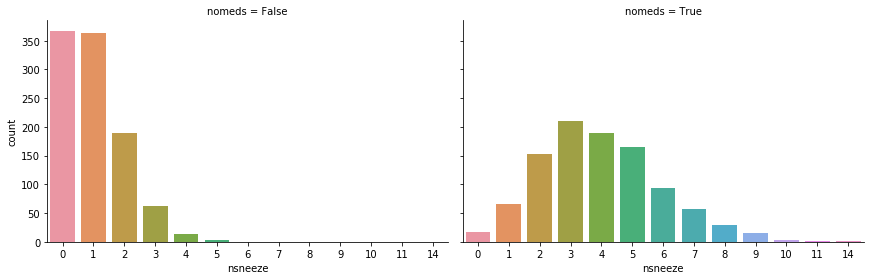

In [36]:
# Average values for nsneezes
print(df.groupby(['nomeds']).mean().unstack())

g = sns.catplot(x='nsneeze',  col='nomeds', data=df,
               kind='count', size=4, aspect=1.5)

The model we use is the following:   
    $ \theta \sim \exp \beta X$  
    $ sneezes \sim Poisson(\theta)$  
Where X is the design matrix, in this case the medication vector.

In [37]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_nomeds', mu=0, sd=10)

    # define linear model and exp link function
    theta = (b0 +
            b1 * df['nomeds'])

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=np.exp(theta), observed=df['nsneeze'].values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b1_nomeds, b0_intercept]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:23<00:00, 1023.72draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0_intercept,-0.000231,0.031884,0.000431,-0.062808,0.061228,5450.140446,1.000429
b1_nomeds,1.381084,0.035677,0.000483,1.310924,1.451724,5563.030803,1.000293


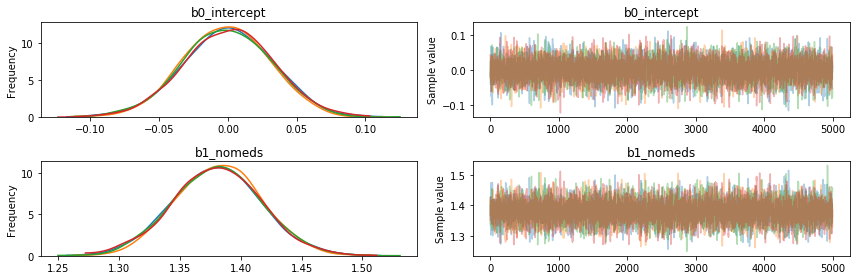

In [38]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

# Descriptive statistic of the posteriors

pm.stats.summary(trace)

In [39]:
np.exp(pm.summary(trace)[['mean','hpd_2.5','hpd_97.5']])


,mean,hpd_2.5,hpd_97.5
b0_intercept,0.999769,0.939123,1.063141
b1_nomeds,3.979213,3.709599,4.270469


# Exercise 2

Try now yourself. 

We have a recording of speed of a car right after the race started. The engineer explains to us that the measuring device always overestimates the actual value.

What was the acceleration of the car? Is the engineer right? 

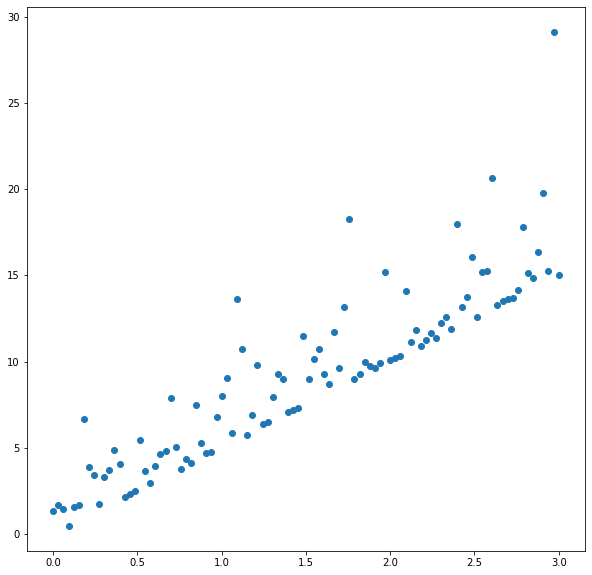

In [40]:
f,ax = plt.subplots(1, figsize = (10,10))
ax.scatter(car_t, car_v)

# Exercise 3

We have the same recording of exercise 1, but now the error seem to be 

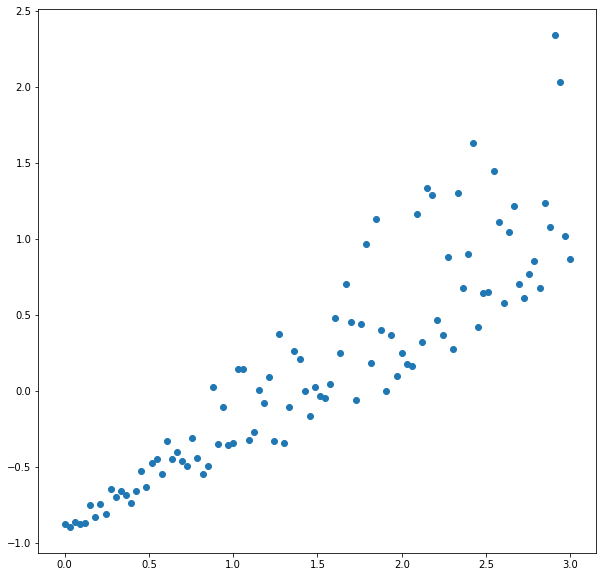

In [41]:
f,ax = plt.subplots(1, figsize = (10,10))
ax.scatter(x, data_h)

## Linear Regression with Outliers


For full example on outliers refer to: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     776.8
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           2.22e-48
Time:                        22:01:40   Log-Likelihood:                 51.217
No. Observations:                 100   AIC:                            -98.43
Df Residuals:                      98   BIC:                            -93.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9568      0.029    -32.908      0.0

Text(0.5, 1.0, 'Observations')

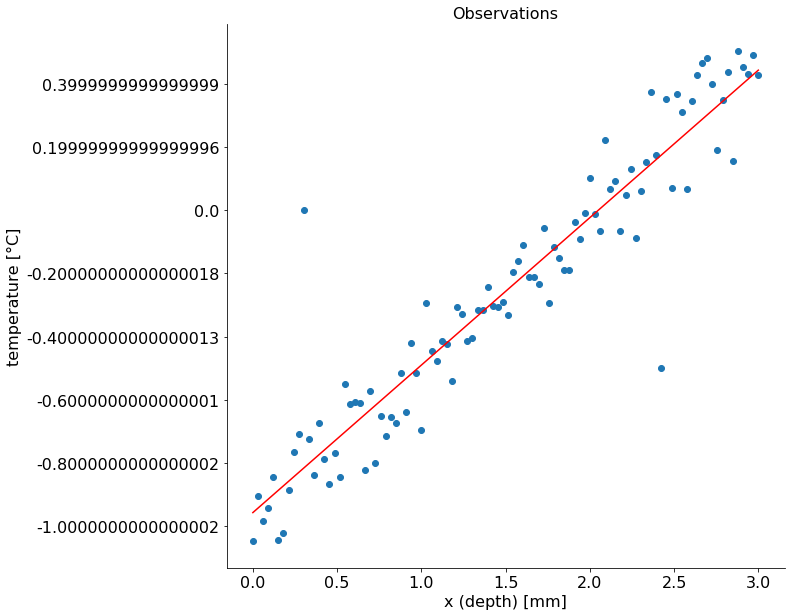

In [42]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_outliers.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_outliers)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, nu, alpha, epsilon]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:23<00:00, 1025.53draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.968732,0.039823,0.000436,-1.045603,-0.889261,8442.304389,0.999962
beta,0.474062,0.022970,0.000241,0.429371,0.519006,8911.999430,0.999937
epsilon,0.038189,0.006069,0.000054,0.026854,0.050301,14296.458667,0.999957
nu,41.147357,27.041727,0.249739,5.056269,92.894041,10063.824239,0.999972


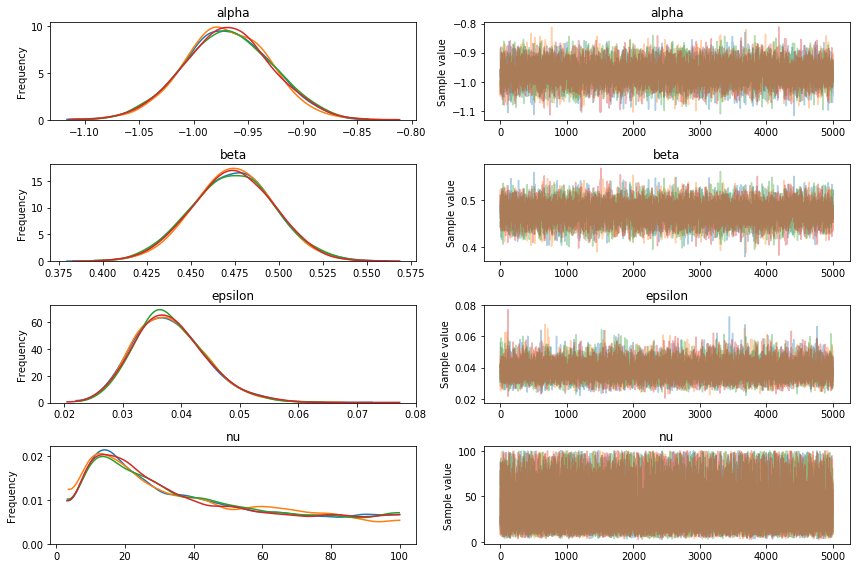

In [43]:
# Data
temperature = data_outliers
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.InverseGamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    nu = pm.Uniform('nu', lower=1,upper = 100)
    beta = pm.Normal('beta', .5, 1)  
    #beta =  pm.StudentT('beta',nu=.5, mu=.5)
    # Likelihood
    #obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )
    obs = pm.StudentT("obs",nu=nu, mu = alpha + depth * beta, sd = np.sqrt(epsilon),observed = temperature )

    ### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

# Descriptive statistic of the posteriors

pm.stats.summary(trace)